## NOTE:

Create a folder named `data` in the files tab and upload the dataset files from https://github.com/uom-cse-realitix/text-classification-fyp/tree/master/data




## NOTE:
**Tensorflow and Keras versions should same as that in local machine or lstm model won't work.**
Check local versions and use the below cells to change Colab versions accordingly.

In [1]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [12]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
# from keras.utils.vis_utils import plot_model
from imblearn.over_sampling import SMOTE

import nltk
import numpy as np

# The maximum number of words to be used. (most frequent)
from tensorflow.keras.models import load_model


In [3]:

MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 32
# Stop words
stopwords_list = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
                  "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its",
                  "itself", "they", "them", "their", "theirs", "themselves", "which", "who", "whom", "these",
                  "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
                  "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
                  "until", "while", "of", "at", "by", "for", "with", "against", "into", "through", "during",
                  "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
                  "under", "again", "further", "then", "once", "here", "there", "when", "why", "how", "all", "any",
                  "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own",
                  "same", "so", "than", "too", "very", "s", "t", "don", "should", "now"]


def import_and_prepare(filepath):
    df = pd.read_csv(filepath, names=['sentence', 'operation'], sep=',', engine='python')
    # df = shuffle(df)
    sentences = df['sentence'].values
    y = df['operation'].values
    return df, sentences, y


def filter_stopwords(sentences, stopwords_list):
    stopwords_set = set(stopwords_list)
    filtered = []
    for sentence in sentences:
        tokenized_sentence = word_tokenize(sentence)
        filtered_sentence = []
        for w in tokenized_sentence:
            if w not in stopwords_set:
                filtered_sentence.append(w)
        filtered.append(filtered_sentence)
    return filtered


def detokenize(filtered_sentences):
    detokenized_sentences = []
    for sentence in filtered_sentences:
        detokenized_sentences.append(TreebankWordDetokenizer().detokenize(sentence))
    return detokenized_sentences


def plot_history(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


def plot_label_distribution(dataframe):
    dataframe['operation'].value_counts().plot(kind="bar")


def init_tokenizer(MAX_NB_WORDS, dataframe):
    tokenizer = Tokenizer(MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(dataframe['filtered_sentence'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return tokenizer


def create_model(max_words, embedding_dimensions, X):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dimensions, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def lstm_train(df, tokenizer, max_sequence_length, embedding_dimensions):
    X = tokenizer.texts_to_sequences(df['filtered_sentence'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    Y = pd.get_dummies(df['operation']).values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

    # Oversampling the minority class
    smote = SMOTE('minority')
    X_train, Y_train = smote.fit_sample(X_train, Y_train)

    model = create_model(max_sequence_length, embedding_dimensions, X)
    epochs = 150
    batch_size = 100
    history = model.fit(X_train, Y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

    accr = model.evaluate(X_test, Y_test)
    print(model.summary())
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))
    # plot_model(model, to_file='model.png')
    return model, history

def infer(sentence, tokenizer, model):
    sentence_as_array = [sentence]
    filtered_commands = filter_stopwords(sentence_as_array, stopwords_list)
    seq = tokenizer.texts_to_sequences(filtered_commands)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    return pred

def pre_initialize():
    df, sentences, y = import_and_prepare('data/dataset_new.txt')
    # df_temp, sentences_temp, y_temp = import_and_prepare('data/dataset_new.txt')
    plot_label_distribution(df)
    filtered_sentences = filter_stopwords(sentences, stopwords_list)
    detokenized_sentences = detokenize(filtered_sentences)
    df['filtered_sentence'] = detokenized_sentences
    tokenizer = init_tokenizer(MAX_NB_WORDS, df)
    return df, tokenizer

Found 164 unique tokens.
Shape of data tensor: (709, 250)


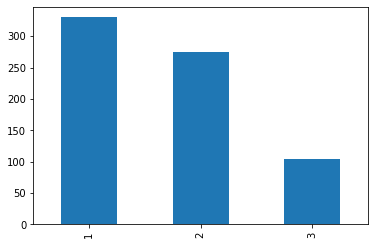

In [13]:
df, tokenizer = pre_initialize()

X = tokenizer.texts_to_sequences(df['filtered_sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = df['operation'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [30]:
object_dictionary = {
    64: {"operation": None, "object_id": 6, "multiple": True, "pointing": False},
    87: {"operation": None, "object_id": 4, "multiple": True, "pointing": False},
    66: {"operation": None, "object_id": 0, "multiple": True, "pointing": False},
    73: {"operation": None, "object_id": 3, "multiple": True, "pointing": False},
    83: {"operation": None, "object_id": 7, "multiple": True, "pointing": False},
    88: {"operation": None, "object_id": 9, "multiple": True, "pointing": False},
    78: {"operation": None, "object_id": 8, "multiple": True, "pointing": False},
    71: {"operation": None, "object_id": 5, "multiple": True, "pointing": False},
    65: {"operation": None, "object_id": 2, "multiple": True, "pointing": False},
    10: {"operation": None, "object_id": 6, "multiple": False, "pointing": False},
    19: {"operation": None, "object_id": 4, "multiple": False, "pointing": False},
    11: {"operation": None, "object_id": 0, "multiple": False, "pointing": False},
    18: {"operation": None, "object_id": 3, "multiple": False, "pointing": False},
    21: {"operation": None, "object_id": 7, "multiple": False, "pointing": False},
    20: {"operation": None, "object_id": 9, "multiple": False, "pointing": False},
    14: {"operation": None, "object_id": 8, "multiple": False, "pointing": False},
    13: {"operation": None, "object_id": 5, "multiple": False, "pointing": False},
    16: {"operation": None, "object_id": 2, "multiple": False, "pointing": False}
}

In [41]:
name_dictionary = {}

for key in object_dictionary.keys():
    new_key = tokenizer.sequences_to_texts([[key]])[0]
    name_dictionary[new_key] = object_dictionary[key]

In [42]:
name_dictionary

{'laptops': {'operation': None,
  'object_id': 6,
  'multiple': True,
  'pointing': False},
 'phones': {'operation': None,
  'object_id': 4,
  'multiple': True,
  'pointing': False},
 'books': {'operation': None,
  'object_id': 0,
  'multiple': True,
  'pointing': False},
 'bottles': {'operation': None,
  'object_id': 3,
  'multiple': True,
  'pointing': False},
 'pens': {'operation': None,
  'object_id': 7,
  'multiple': True,
  'pointing': False},
 'cups': {'operation': None,
  'object_id': 9,
  'multiple': True,
  'pointing': False},
 'keyboards': {'operation': None,
  'object_id': 8,
  'multiple': True,
  'pointing': False},
 'mouses': {'operation': None,
  'object_id': 5,
  'multiple': True,
  'pointing': False},
 'monitors': {'operation': None,
  'object_id': 2,
  'multiple': True,
  'pointing': False},
 'laptop': {'operation': None,
  'object_id': 6,
  'multiple': False,
  'pointing': False},
 'phone': {'operation': None,
  'object_id': 4,
  'multiple': False,
  'pointing': Fals

['laptops phones books bottles pens cups keyboards mouses monitors laptop phone book bottle pen cup keyboard mouse monitor']

In [23]:
classifier = svm.SVC(kernel='rbf', gamma='scale')
classifier.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
predictions = classifier.predict(X_train)
print(accuracy_score(Y_train, predictions))

0.7721280602636534


In [25]:
predictions = classifier.predict(X_test)
print(accuracy_score(Y_test, predictions))

0.7471910112359551


Found 164 unique tokens.
Shape of data tensor: (709, 250)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[nltk_data] Downloading package punkt to /home/darshanakg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Train on 624 samples, validate on 70 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
624/624 [==============================] - 3s 5ms/sample - loss: 3.9172 - acc: 0.3750 - val_loss: 3.6302 - val_acc: 0.0000e+00
Epoch 2/150
624/624 [==============================] - 2s 3ms/sample - loss: 3.3093 - acc: 0.3926 - val_loss: 3.1254 - val_acc: 0.0000e+00
Epoch 3/150
624/624 [==============================] - 2s 3ms/sample - loss: 2.7932 - acc: 0.4535 - val_loss: 2.6747 - val_acc: 0.0000e+00
Epoch 4/150
624/624 [==============================] - 2s 3ms/sample - loss: 2.3494 - acc: 0.5449 - val_loss: 2.3067 - val_acc: 0.0000e+00
Epoch 5/150
624/624 [==============================] - 2s 3ms/sample - loss: 1.9515 - acc: 0.6058 - val_loss: 1.8900 - val_acc: 0.3857
Epoch 6/150
624/624 [==============================] - 2s 4ms/sample - loss: 1.5758 - acc: 0.8558 - val_loss: 1.8188 - val_acc: 0.1571
Epoch 7/150
624/624 [==============================] - 2s 3ms/sample - loss: 1.31

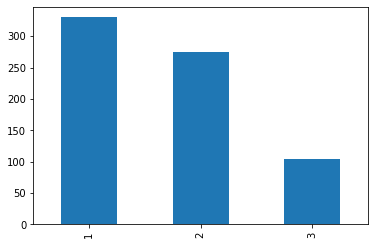

In [6]:
# df, sentences, y = import_and_prepare('data/dataset.txt')
nltk.download('punkt')

df, tokenizer = pre_initialize()
model, history = lstm_train(df, tokenizer, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH)
model.save('lstm.h5')
# plot_history(history)

In [8]:
model = load_model('./lstm.h5')
new_command = ['Track the pen']
filtered_commands = filter_stopwords(new_command, stopwords_list)
seq = tokenizer.texts_to_sequences(filtered_commands)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

labels = ['Locate', 'Describe', 'No_Op']
print("Predicted vector: ", pred, " Predicted Class: ", labels[np.argmax(pred)])

Predicted vector:  [[0.9701294  0.00708048 0.02279018]]  Predicted Class:  Locate
